# Graph Attention Network

This notebook will demonstrate how to predict LogS and LogP with the help of a Graph Attention Network (GAT)


In [132]:
!pip install rdkit
!pip install torch-geometric

## Setting up and importing necessary libraries

In [133]:
import random
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GATConv, global_mean_pool
from rdkit import Chem
from rdkit.Chem import AllChem
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load Dataset

In [134]:
data_path = 'ESolv-Rdkit-Features.csv'
df = pd.read_csv(data_path)
df = df.rename(columns={
    'Compound ID': 'name',
    'smiles': 'smiles',
    'measured log solubility in mols per litre': 'logS',
    'LogP': 'logP'
})

In [135]:
scaler_logS = StandardScaler()
df['logS_scaled'] = scaler_logS.fit_transform(df[['logS']])
scaler_logP = StandardScaler()
df['logP_scaled'] = scaler_logP.fit_transform(df[['logP']])

## Convert each molecule to a graph, build the dataset and the dataloaders

Each molecule is converted to a graph, where each node represents an atom and the bonds represent the edges between them. The atoms features like

- Degree
- Formal Charge
- Hybridization
- Atomic Number, etc.

make the node features.

In [136]:
COMMON_ATOMS =set() #Atomic numbers of all atoms in dataset
for smile in df["smiles"]:
    mol = Chem.MolFromSmiles(smile)
    for atom in mol.GetAtoms():
        COMMON_ATOMS.add(atom.GetAtomicNum())
COMMON_ATOMS.add(1) #Hydrogen is not explicitly present in mol.GetAtoms()
COMMON_ATOMS = sorted(list(COMMON_ATOMS))
print(COMMON_ATOMS)

def one_hot_atomic_number(atomic_num):
    idx = COMMON_ATOMS.index(atomic_num) if atomic_num in COMMON_ATOMS else len(COMMON_ATOMS)
    return F.one_hot(torch.tensor(idx), num_classes=len(COMMON_ATOMS) + 1).float()

def atom_features(atom):
    features = torch.cat([
        one_hot_atomic_number(atom.GetAtomicNum()),  # one-hot atomic number
        torch.tensor([
            atom.GetDegree(),
            atom.GetFormalCharge(),
            atom.GetHybridization().real,
            atom.GetIsAromatic()
        ], dtype=torch.float)
    ])
    return features

[1, 6, 7, 8, 9, 15, 16, 17, 35, 53]


In [137]:
from rdkit.Chem.rdchem import BondType
BOND_TYPES = [
    BondType.SINGLE,
    BondType.DOUBLE,
    BondType.TRIPLE,
    BondType.AROMATIC
]

def one_hot_bond_type(bond_type):
    idx = BOND_TYPES.index(bond_type) if bond_type in BOND_TYPES else len(BOND_TYPES)
    return F.one_hot(torch.tensor(idx), num_classes=len(BOND_TYPES) + 1).float()

def bond_features(bond):
    features = torch.cat([
        one_hot_bond_type(bond.GetBondType()),  # one-hot bond type
        torch.tensor([
            bond.GetIsConjugated(),
            bond.IsInRing()
        ], dtype=torch.float)
    ])
    return features

In [138]:
def mol_to_graph(smiles, logS, logP):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None


    x = torch.stack([atom_features(atom) for atom in mol.GetAtoms()])

    # Extract edge indices and edge attributes
    edge_index = [[], []]
    edge_attr = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        # Add both directions for undirected graph
        edge_index[0] += [i, j]
        edge_index[1] += [j, i]
        # Add bond features for both directions
        bond_feat = bond_features(bond)
        edge_attr.append(bond_feat)
        edge_attr.append(bond_feat)

    edge_index = torch.tensor(edge_index, dtype=torch.long)
    edge_attr = torch.stack(edge_attr) if edge_attr else torch.empty((0, 7), dtype=torch.float)

    # Combine into a single Data object with targets
    y = torch.tensor([logS, logP], dtype=torch.float)
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    return data

In [139]:
dataset = []
for _, row in tqdm(df.iterrows(), total=len(df)):
    graph = mol_to_graph(row['smiles'], row['logS_scaled'], row['logP_scaled'])
    if graph is not None:
        graph.name = row['name']
        dataset.append(graph)

random.shuffle(dataset)
print(f'Total molecules converted to graphs: {len(dataset)}')

100%|██████████| 1128/1128 [00:04<00:00, 252.21it/s]

Total molecules converted to graphs: 1128


In [140]:
from torch.utils.data import random_split
train_ds,test_ds = random_split(dataset,[0.8,0.2])
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)


/tmp/ipython-input-475065560.py:3: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
/tmp/ipython-input-475065560.py:4: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)


In [141]:
node_feature_size=train_ds[0].x.shape[1]

## Defining the model, optimizer and loss criterion

In [142]:
class GATNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GATNet, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=4, dropout=0.1)
        self.conv2 = GATConv(hidden_channels * 4, hidden_channels, heads=4, dropout=0.1)
        self.lin = torch.nn.Linear(hidden_channels * 4, out_channels)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)

# Instantiate model, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GATNet(in_channels=node_feature_size, hidden_channels=32, out_channels=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

## Training and Evaluating the model

In [143]:
def train():
    model.train()
    total_loss = 0.0
    total_logS = 0.0
    total_logP = 0.0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        pred = model(batch)

        target = batch.y.view(batch.num_graphs, -1)  # Reshape to [batch_size, 2]

        loss_logS = F.mse_loss(pred[:, 0], target[:, 0])
        loss_logP = F.mse_loss(pred[:, 1], target[:, 1])
        loss = (loss_logS + loss_logP)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_logS += loss_logS.item()
        total_logP += loss_logP.item()

    avg_loss = total_loss / len(train_loader)
    avg_logS = total_logS / len(train_loader)
    avg_logP = total_logP / len(train_loader)
    return avg_loss, avg_logS, avg_logP

In [144]:
def evaluate(loader):
    model.eval()
    total_loss = 0.0
    total_logS = 0.0
    total_logP = 0.0
    total_graphs = 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred = model(batch)
            target = batch.y.view(batch.num_graphs, -1)  # Reshape to [batchsize, 2]

            loss_logS = F.mse_loss(pred[:, 0], target[:, 0])
            loss_logP = F.mse_loss(pred[:, 1], target[:, 1])
            loss = (loss_logS + loss_logP)

            total_loss += loss.item()
            total_logS += loss_logS.item()
            total_logP += loss_logP.item()

    avg_loss = total_loss / len(loader)
    avg_logS = total_logS / len(loader)
    avg_logP = total_logP / len(loader)
    return avg_loss, avg_logS, avg_logP

Setting the hyperparameters

In [145]:
EPOCHS = 100

train_losses = []
val_losses = []
train_logS_losses = []
val_logS_losses = []
train_logP_losses = []
val_logP_losses = []

for epoch in range(1, EPOCHS + 1):
    train_loss, train_logS, train_logP = train()
    val_loss, val_logS, val_logP = evaluate(test_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_logS_losses.append(train_logS)
    val_logS_losses.append(val_logS)
    train_logP_losses.append(train_logP)
    val_logP_losses.append(val_logP)

    print(f'Epoch: {epoch:03d} | Train MSE: logS={train_logS:.4f}, logP={train_logP:.4f} | Val MSE: logS={val_logS:.4f}, logP={val_logP:.4f}')

Epoch: 001 | Train MSE: logS=0.9387, logP=0.9691 | Val MSE: logS=0.8344, logP=0.7271
Epoch: 002 | Train MSE: logS=0.8312, logP=0.8944 | Val MSE: logS=0.7082, logP=0.5981
Epoch: 003 | Train MSE: logS=0.7073, logP=0.6746 | Val MSE: logS=0.6139, logP=0.4393
Epoch: 004 | Train MSE: logS=0.5775, logP=0.5063 | Val MSE: logS=0.5641, logP=0.4021
Epoch: 005 | Train MSE: logS=0.5513, logP=0.4659 | Val MSE: logS=0.5551, logP=0.4111
Epoch: 006 | Train MSE: logS=0.5158, logP=0.4472 | Val MSE: logS=0.5216, logP=0.3527
Epoch: 007 | Train MSE: logS=0.4816, logP=0.4051 | Val MSE: logS=0.5318, logP=0.3601
Epoch: 008 | Train MSE: logS=0.4634, logP=0.4011 | Val MSE: logS=0.4960, logP=0.3321
Epoch: 009 | Train MSE: logS=0.4549, logP=0.3806 | Val MSE: logS=0.4709, logP=0.3291
Epoch: 010 | Train MSE: logS=0.4383, logP=0.3818 | Val MSE: logS=0.4490, logP=0.3133
Epoch: 011 | Train MSE: logS=0.4309, logP=0.3628 | Val MSE: logS=0.4679, logP=0.3284
Epoch: 012 | Train MSE: logS=0.4060, logP=0.3471 | Val MSE: logS=

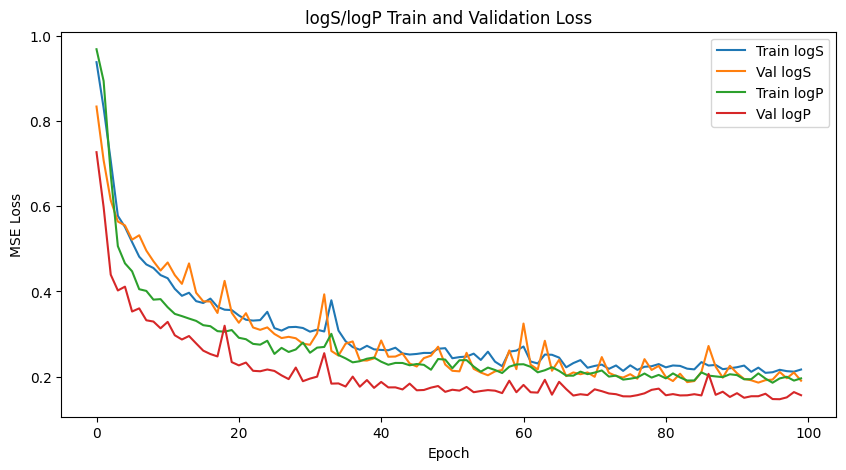

In [146]:
plt.figure(figsize=(10, 5))
plt.plot(train_logS_losses, label='Train logS')
plt.plot(val_logS_losses, label='Val logS')
plt.plot(train_logP_losses, label='Train logP')
plt.plot(val_logP_losses, label='Val logP')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('logS/logP Train and Validation Loss')
plt.legend()
plt.show()

Test Set Performance Metrics (Original Scale)

logS Metrics:
  MSE:  0.9427
  RMSE: 0.9709
  MAE:  0.7151
  R²:   0.7924

logP Metrics:
  MSE:  0.5973
  RMSE: 0.7728
  MAE:  0.5596
  R²:   0.8130


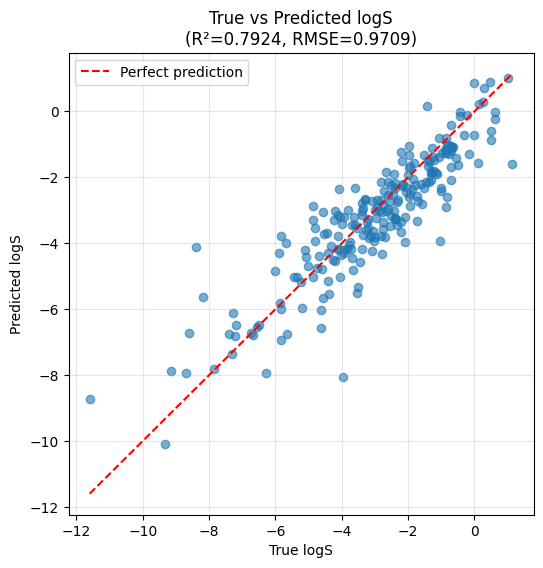

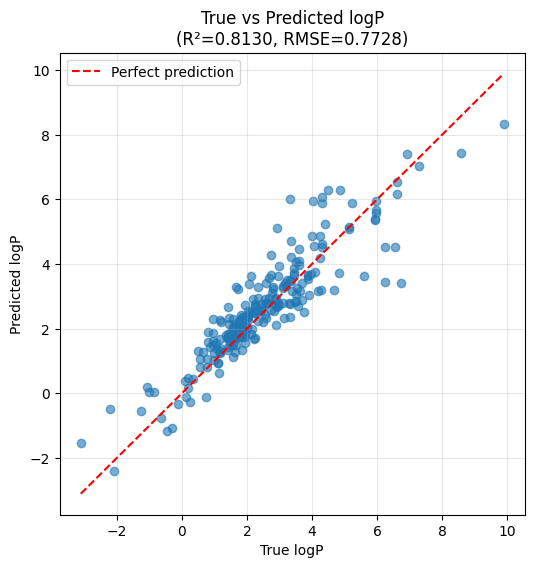

In [147]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# evaluate the model by predicting on test set
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred = model(batch)
        all_preds.append(pred.cpu())
        targets = batch.y.view(batch.num_graphs, -1).cpu()
        all_targets.append(targets)

# concatenate scaled predictions and targets
all_preds = torch.cat(all_preds, dim=0)
all_targets = torch.cat(all_targets, dim=0)

# inverse transform to original scale
pred_logS_scaled = all_preds[:, 0].numpy().reshape(-1, 1)
pred_logP_scaled = all_preds[:, 1].numpy().reshape(-1, 1)
true_logS_scaled = all_targets[:, 0].numpy().reshape(-1, 1)
true_logP_scaled = all_targets[:, 1].numpy().reshape(-1, 1)

pred_logS = scaler_logS.inverse_transform(pred_logS_scaled).ravel()
pred_logP = scaler_logP.inverse_transform(pred_logP_scaled).ravel()
true_logS = scaler_logS.inverse_transform(true_logS_scaled).ravel()
true_logP = scaler_logP.inverse_transform(true_logP_scaled).ravel()

# Calculate metrics for logS
mse_logS = mean_squared_error(true_logS, pred_logS)
rmse_logS = np.sqrt(mse_logS)
mae_logS = mean_absolute_error(true_logS, pred_logS)
r2_logS = r2_score(true_logS, pred_logS)

# Calculate metrics for logP
mse_logP = mean_squared_error(true_logP, pred_logP)
rmse_logP = np.sqrt(mse_logP)
mae_logP = mean_absolute_error(true_logP, pred_logP)
r2_logP = r2_score(true_logP, pred_logP)

# Print metrics
print("=" * 60)
print("Test Set Performance Metrics (Original Scale)")
print("=" * 60)
print(f"\nlogS Metrics:")
print(f"  MSE:  {mse_logS:.4f}")
print(f"  RMSE: {rmse_logS:.4f}")
print(f"  MAE:  {mae_logS:.4f}")
print(f"  R²:   {r2_logS:.4f}")

print(f"\nlogP Metrics:")
print(f"  MSE:  {mse_logP:.4f}")
print(f"  RMSE: {rmse_logP:.4f}")
print(f"  MAE:  {mae_logP:.4f}")
print(f"  R²:   {r2_logP:.4f}")
print("=" * 60)

# plot the regression results for logS
plt.figure(figsize=(6, 6))
plt.scatter(true_logS, pred_logS, alpha=0.6)
min_s = min(true_logS.min(), pred_logS.min())
max_s = max(true_logS.max(), pred_logS.max())
plt.plot([min_s, max_s], [min_s, max_s], 'r--', label='Perfect prediction')
plt.xlabel('True logS')
plt.ylabel('Predicted logS')
plt.title(f'True vs Predicted logS\n(R²={r2_logS:.4f}, RMSE={rmse_logS:.4f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# plot the regression results for logP
plt.figure(figsize=(6, 6))
plt.scatter(true_logP, pred_logP, alpha=0.6)
min_p = min(true_logP.min(), pred_logP.min())
max_p = max(true_logP.max(), pred_logP.max())
plt.plot([min_p, max_p], [min_p, max_p], 'r--', label='Perfect prediction')
plt.xlabel('True logP')
plt.ylabel('Predicted logP')
plt.title(f'True vs Predicted logP\n(R²={r2_logP:.4f}, RMSE={rmse_logP:.4f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()